<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Personal%20Projects/COVIDadverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task: Exploring Covid-19 and non-Covid vaccine reports VAERS 2020

During investigations of safety concerns with medicinal products, pharmacovigilance experts will evaluate the causality between the medicinal product and the observed side effect. For this, they need as much information as possible to understand each report and what happened to that patient in as much detail as possible. They do not usually have the possibility to reach the patient and ask follow up questions. They therefore rely not only on structured information but also on the narrative descriptions of the side effect if available. These can include information about the course of events, the symptoms, the severity and quality of life of the patient but also information about concomitant factors such as other drugs or other differential diagnosis. Reports of suspected side effects can be sent by different reporters, for example the patient themselves, health care professionals or pharmaceutical companies.

Here, I will look at reports from VAERS in 2020, the US database for adverse events reported for vaccines, available here: https://vaers.hhs.gov/data/datasets.html. **Use the CSV files VAERS DATA and VAERS VACCINE** (both files contain a unique ID VAERS_ID for linking the tables). The narrative field is in the VAERS DATA file in column SYMPTOM_TEXT but there exist other free-text fields on the reports. The vaccine information can be found in the VAERS VACCINE/VAX file the column VAX_NAME contains the vaccine name for the report and you can identify the COVID19 reports using this column. Since the data is from the US in 2020, it includes reports for Covid-19 vaccines and other vaccines.

 **Are COVID-19 vaccine narratives different from narratives for other vaccines??**

* Are more or less narratives written in the first person?
* Is there more redundancy in covid-19 vaccine narratives?


Explanation of the dataset: https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import re
import cv2
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import groupby
from operator import itemgetter
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, classification_report, accuracy_score
from scipy.stats import kruskal, f_oneway
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors, metrics)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.feature_selection import (f_classif, VarianceThreshold, chi2, mutual_info_classif, SelectKBest,
                                       SelectPercentile, SelectFromModel)
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


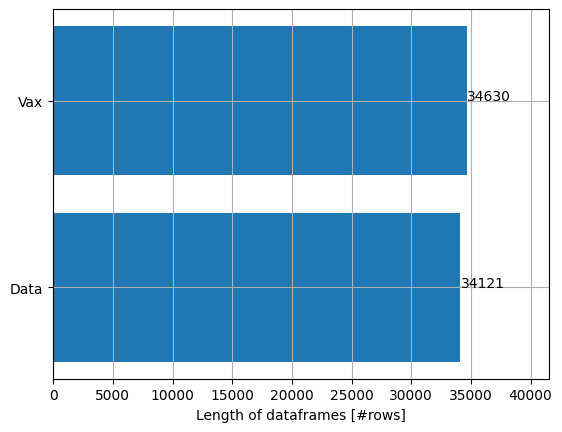

In [3]:
#open and load files:
analysisFolder = '/content/drive/MyDrive/Colab Notebooks/Pharmacovigilance/Covid_adverseRx/archive/'
picFolder = analysisFolder + 'Figs'

df_data = pd.read_csv(analysisFolder + '2021VAERSDATA.csv', delimiter=',', encoding='latin-1')
#df_symp = pd.read_csv(analysisFolder + '2021VAERSSYMPTOMS.csv', delimiter=',', encoding='latin-1')
df_vax = pd.read_csv(analysisFolder + '2021VAERSVAX.csv', delimiter=',', encoding='latin-1')


x = ['Data', 'Vax']
y = [len(df_data), len(df_vax)];
plt.barh(x, y)
for i in range(len(x)):
    plt.text(y[i], i, y[i], ha = 'left')
plt.xlabel('Length of dataframes [#rows]')
plt.xlim([0, np.max(y)*1.2])
plt.grid()
plt.show()



since the data from both dataframes are not the same length, we will need to explore it to find the best way to merge them.

we group by patient ID:

In [4]:
dff = df_data.merge(df_vax, on='VAERS_ID', how='inner')
dff.drop_duplicates(subset='VAERS_ID', keep='first', inplace=True)
dff.reset_index(drop=True, inplace=True)


dff.describe().T

,count,mean,std,min,25%,50%,75%,max
VAERS_ID,34121.0,981306.591190,62045.354319,916600.00,926464.0,946837.0,1047069.0,1115348.0
AGE_YRS,30933.0,51.471923,18.521742,0.08,37.0,50.0,65.0,115.0
CAGE_YR,26791.0,51.135381,18.633316,0.00,36.0,49.0,65.0,106.0
CAGE_MO,83.0,0.084337,0.178395,0.00,0.0,0.0,0.0,0.7
HOSPDAYS,2857.0,3.752888,3.878654,1.00,1.0,3.0,5.0,39.0
NUMDAYS,31194.0,21.077066,644.834400,0.00,0.0,1.0,3.0,36896.0
FORM_VERS,34121.0,1.998124,0.043269,1.00,2.0,2.0,2.0,2.0


In [5]:
dff['bCOVID'] = np.repeat('Y', len(dff))
dff['bCOVID'][dff['VAX_TYPE'] != 'COVID19'] = 'N'

bBool = ['RECOVD', 'DIED']
for var in bBool:
  dff[var][dff[var] != 'Y'] = 'N'


## Descriptive Analysis

In [6]:
print(f'This is an example of the symptoms reported: \n\n{dff.SYMPTOM_TEXT[0]}')

This is an example of the symptoms reported: 

Right side of epiglottis swelled up and hinder swallowing pictures taken Benadryl Tylenol taken


In [7]:
#These are some of the most common words found in the database indicating the non-existing values:
NegL = ['NaN', 'nan', 'None', 'none', 'no known', 'Known Known', 'UKN', 'None noted', 'NA', 'Not known', 'No known allergies.', 'No known allergies', 'not known', 'notknown', 'NKA', 'NKDA', 'No', 'NO', 'none listed', 'none lister', 'NONE', 'none reported']

In [8]:
#Let's fix some of the booleans in the dataframe:
bBool = ['RECOVD', 'DIED']
for var in bBool:
  dff[var][np.in1d(dff[var], NegL)] = 'N'
  dff[var][dff[var] != 'Y'] = 'N'


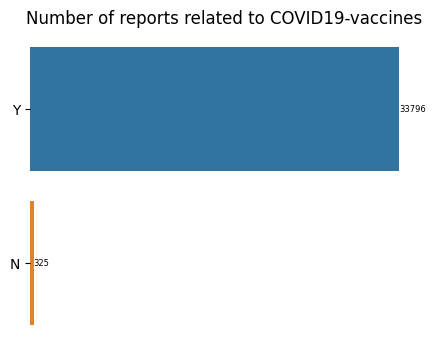

In [60]:
fig, ax = plt.subplots(1,1, figsize = (5,4), sharey = False)
hax = ax;
sns.countplot(ax = hax, data = dff, y = 'bCOVID');
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None);
a = hax.bar_label(hax.containers[0], fontsize = 6);
hax.set_title('Number of reports related to COVID19-vaccines')

plt.show()

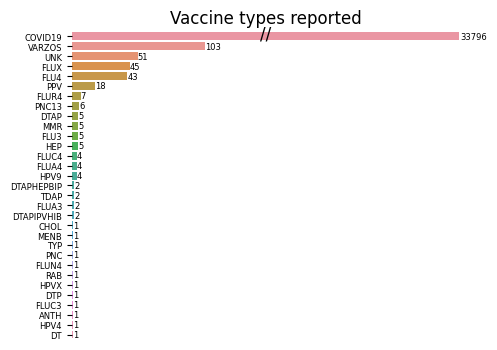

In [9]:
fig, ax = plt.subplots(1,1, figsize = (5,4), sharey = False)
hax = ax;
sns.countplot(ax = hax, data = dff, y = 'VAX_TYPE', order = dff.VAX_TYPE.value_counts().index);
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None, xlim = [0, 300]);
a = hax.bar_label(hax.containers[0], fontsize = 6);
hax.set_yticklabels(labels = dff.VAX_TYPE.value_counts().index, fontsize = 6)
hax.text(301, 0.25, np.sum(dff.VAX_TYPE == 'COVID19'), ha = 'left', fontsize = 6);
hax.text(150, 0.25, '//', ha = 'center', fontsize = 12);
hax.set_title('Vaccine types reported')

plt.show()

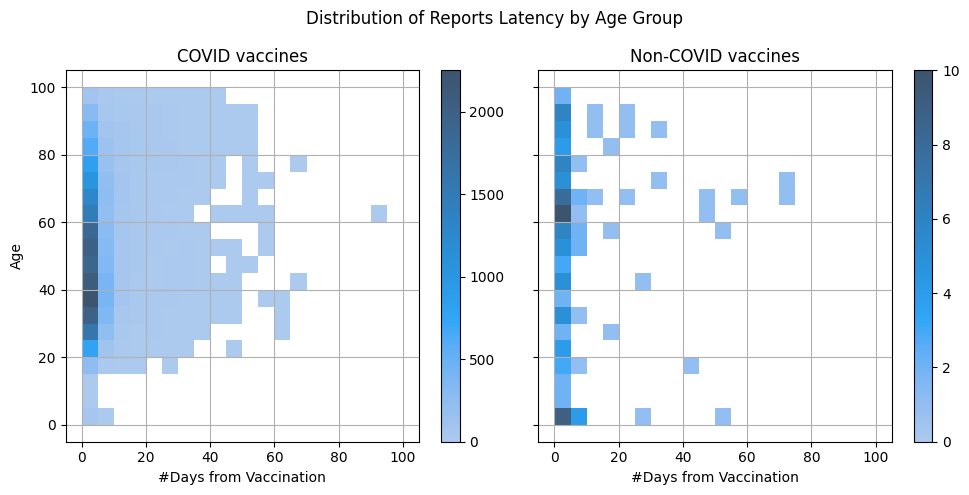

In [10]:
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True)
bins = [*range(0,101,5)]
hax = ax[0]
sns.histplot(ax = hax, data = dff[dff.VAX_TYPE == 'COVID19'], y = 'CAGE_YR', x = 'NUMDAYS', bins = bins, cbar = True);
hax.set(frame_on=True, xlabel = '#Days from Vaccination', ylabel = 'Age')
hax.set_title('COVID vaccines')
hax.grid()

hax = ax[1]
sns.histplot(ax = hax, data = dff[dff.VAX_TYPE != 'COVID19'], y = 'CAGE_YR', x = 'NUMDAYS', bins = bins, cbar = True);
hax.set(frame_on=True, xlabel = '#Days from Vaccination', ylabel = 'Age')
hax.set_title('Non-COVID vaccines')
hax.grid()

plt.suptitle('Distribution of Reports Latency by Age Group')
plt.tight_layout();

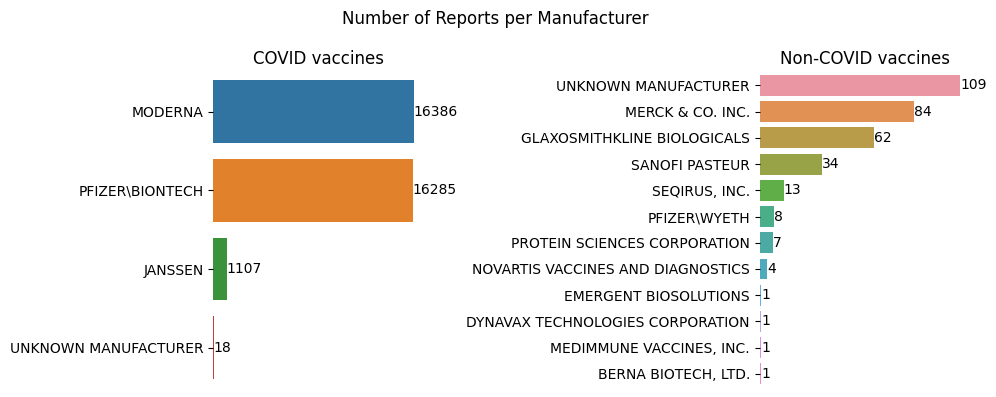

In [11]:
var = 'VAX_MANU'

fig, ax = plt.subplots(1,2, figsize = (10,4), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('Non-COVID vaccines')

plt.suptitle('Number of Reports per Manufacturer')
plt.tight_layout()

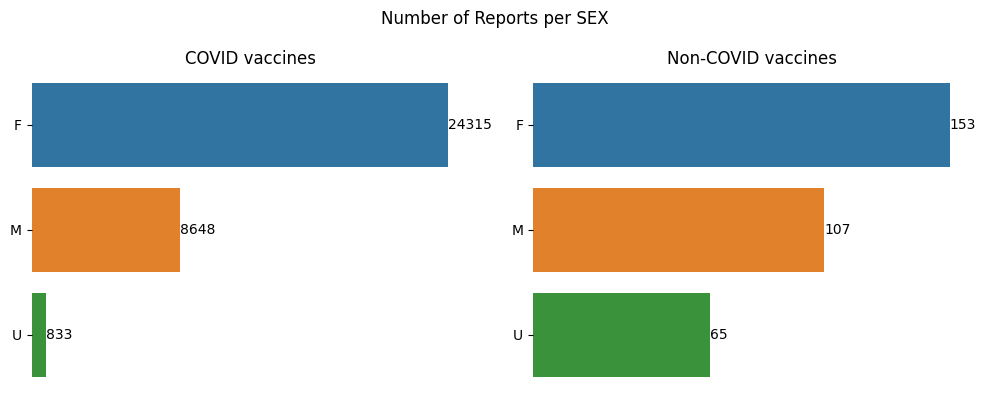

In [12]:
var = 'SEX'

fig, ax = plt.subplots(1,2, figsize = (10,4), sharey = False)
sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('Non-COVID vaccines')

plt.suptitle('Number of Reports per SEX')
plt.tight_layout()

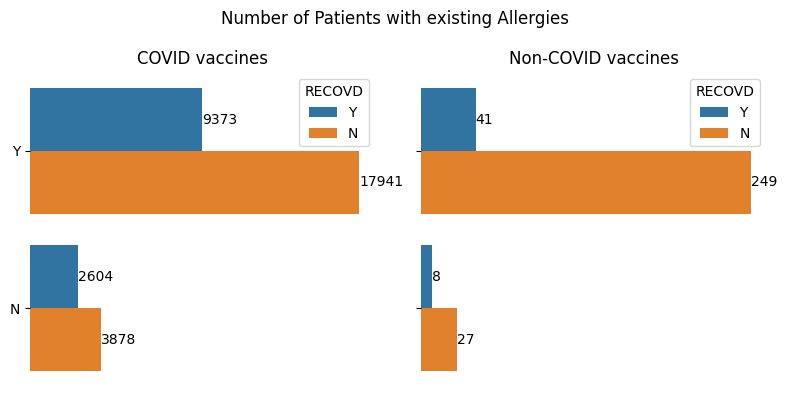

In [13]:
var = 'ALLERGIES'
dummy = dff.copy()
dummy['logAllergies'] = np.repeat('Y', len(dff))
dummy['logAllergies'][np.in1d(dff[var], NegL)] = 'N'

fig, ax = plt.subplots(1,2, figsize = (8,4), sharey = True)
sel = (dff.VAX_TYPE == 'COVID19')
hax = ax[0]
sns.countplot(ax = hax, data = dummy[sel], y = 'logAllergies', hue = 'RECOVD', order = dummy['logAllergies'][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.bar_label(hax.containers[1]);
hax.set_title('COVID vaccines')

sel = (dff.VAX_TYPE != 'COVID19')
hax = ax[1]
sns.countplot(ax = hax, data = dummy[sel], y = 'logAllergies', hue = 'RECOVD', order = dummy['logAllergies'][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.bar_label(hax.containers[1]);
hax.set_title('Non-COVID vaccines')

plt.suptitle('Number of Patients with existing Allergies')
plt.tight_layout()

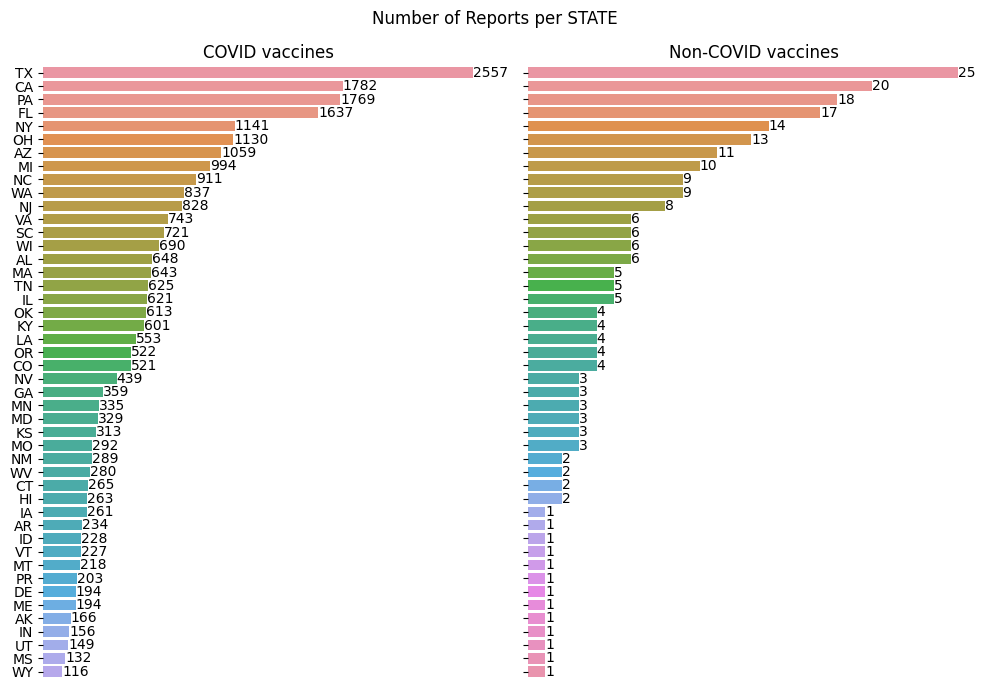

In [53]:
var = 'STATE'

fig, ax = plt.subplots(1,2, figsize = (10,7), sharey = True)
sel = (dff.bCOVID == 'Y')
hax = ax[0]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('COVID vaccines')

sel = (dff.bCOVID != 'Y')
hax = ax[1]
sns.countplot(ax = hax, data = dff[sel], y = var, order = dff[var][sel].value_counts().index)
hax.set(frame_on=False, xticks=[], xlabel = None, ylabel = None)
hax.bar_label(hax.containers[0]);
hax.set_title('Non-COVID vaccines')

plt.suptitle('Number of Reports per STATE')
plt.tight_layout()

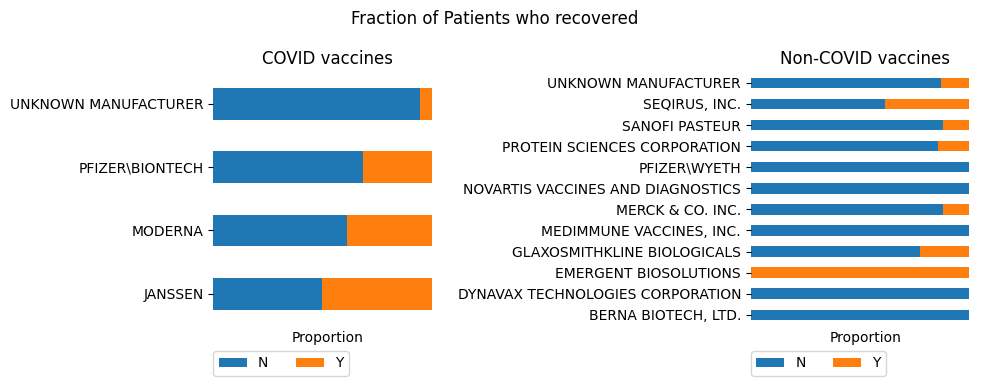

In [62]:
sel = dff.VAX_TYPE == 'COVID19'

fig, ax = plt.subplots(1,2, figsize = (10,4))
hax = ax[0]
tabProp = pd.crosstab(index = dff[sel]['VAX_MANU'], columns = dff[sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dff[~sel]['VAX_MANU'], columns = dff[~sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'Non-COVID vaccines')
plt.suptitle('Fraction of Patients who recovered')
plt.tight_layout()

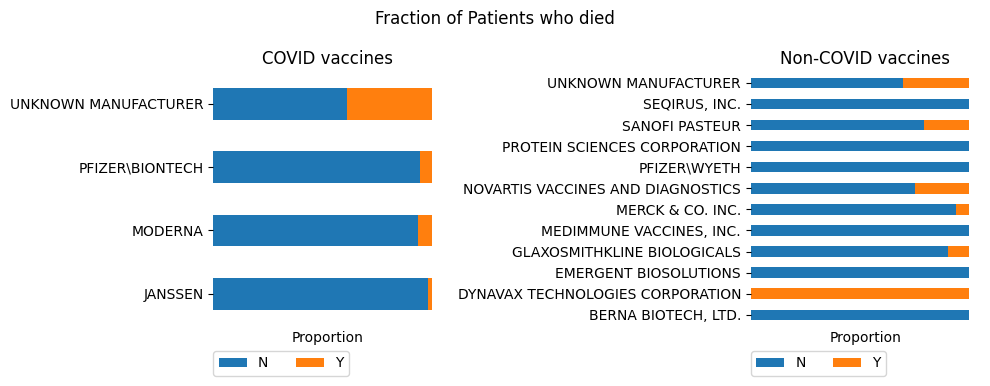

In [63]:
sel = dff.VAX_TYPE == 'COVID19'

dummy = dff.copy()
dummy.DIED[dummy.DIED != 'Y'] = 'N'
fig, ax = plt.subplots(1,2, figsize = (10,4))
hax = ax[0]
tabProp = pd.crosstab(index = dummy[sel]['VAX_MANU'], columns = dummy[sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dummy[~sel]['VAX_MANU'], columns = dummy[~sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'Non-COVID vaccines')
plt.suptitle('Fraction of Patients who died')
plt.tight_layout()

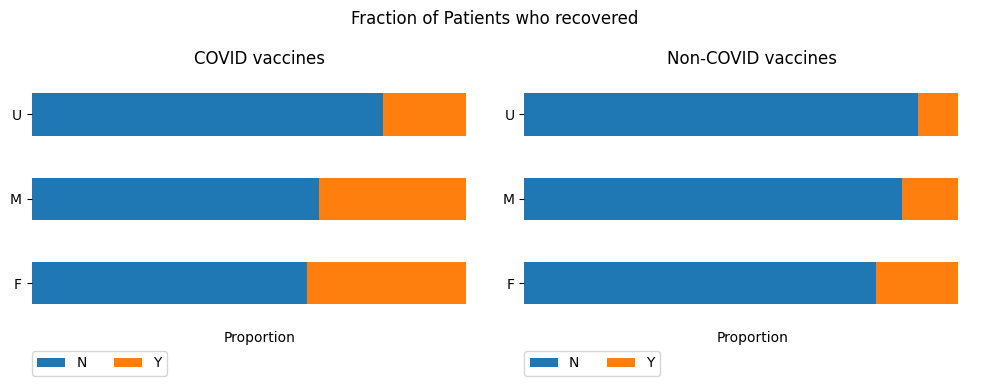

In [65]:
sel = dff.VAX_TYPE == 'COVID19'

fig, ax = plt.subplots(1,2, figsize = (10,4))
hax = ax[0]
tabProp = pd.crosstab(index = dff[sel]['SEX'], columns = dff[sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dff[~sel]['SEX'], columns = dff[~sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'Non-COVID vaccines')
plt.suptitle('Fraction of Patients who recovered')
plt.tight_layout()

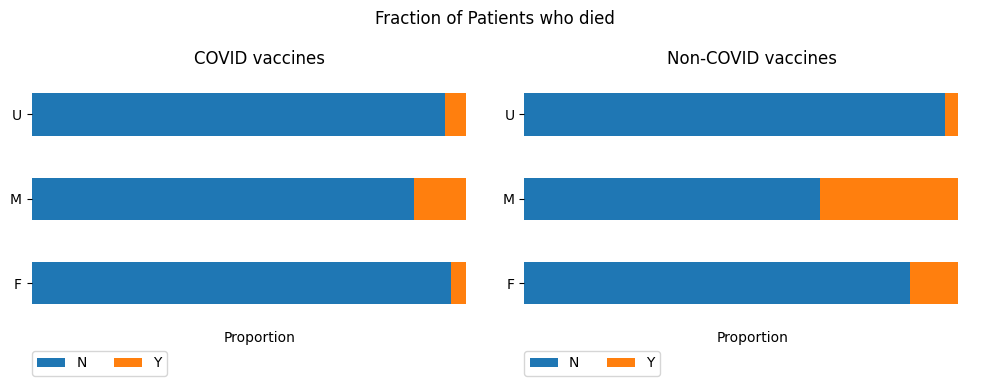

In [67]:
sel = dff.VAX_TYPE == 'COVID19'

dummy = dff.copy()
dummy.DIED[dummy.DIED != 'Y'] = 'N'
fig, ax = plt.subplots(1,2, figsize = (10,4))
hax = ax[0]
tabProp = pd.crosstab(index = dummy[sel]['SEX'], columns = dummy[sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dummy[~sel]['SEX'], columns = dummy[~sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'Non-COVID vaccines')
plt.suptitle('Fraction of Patients who died')
plt.tight_layout()

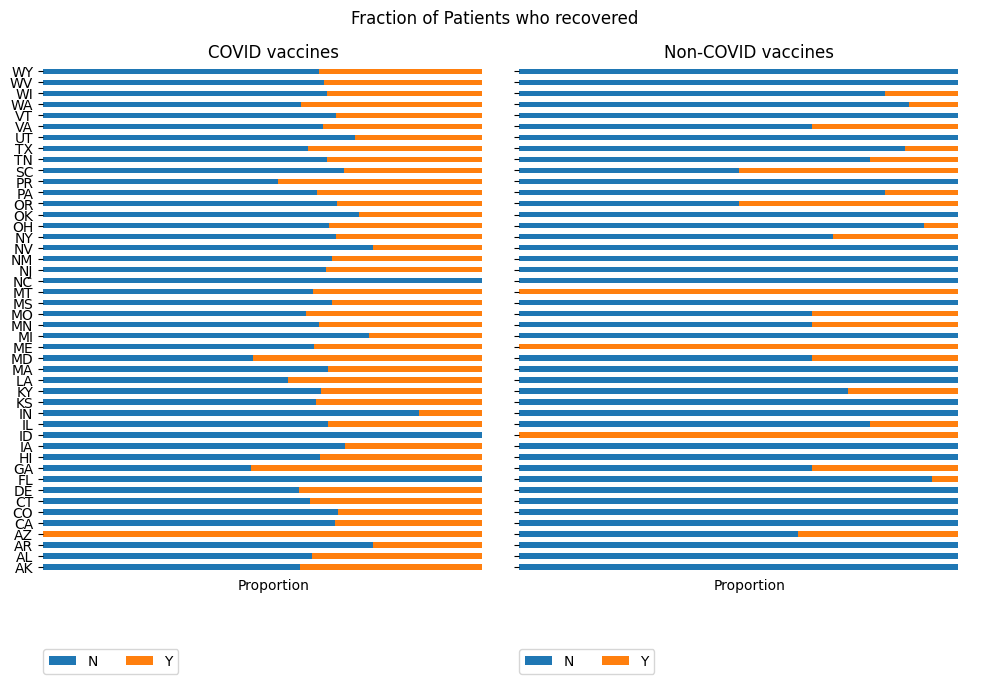

In [68]:
sel = dff.VAX_TYPE == 'COVID19'

fig, ax = plt.subplots(1,2, figsize = (10,7), sharey = True)
hax = ax[0]
tabProp = pd.crosstab(index = dff[sel]['STATE'], columns = dff[sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dff[~sel]['STATE'], columns = dff[~sel]['RECOVD'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'Non-COVID vaccines')
plt.suptitle('Fraction of Patients who recovered')
plt.tight_layout()

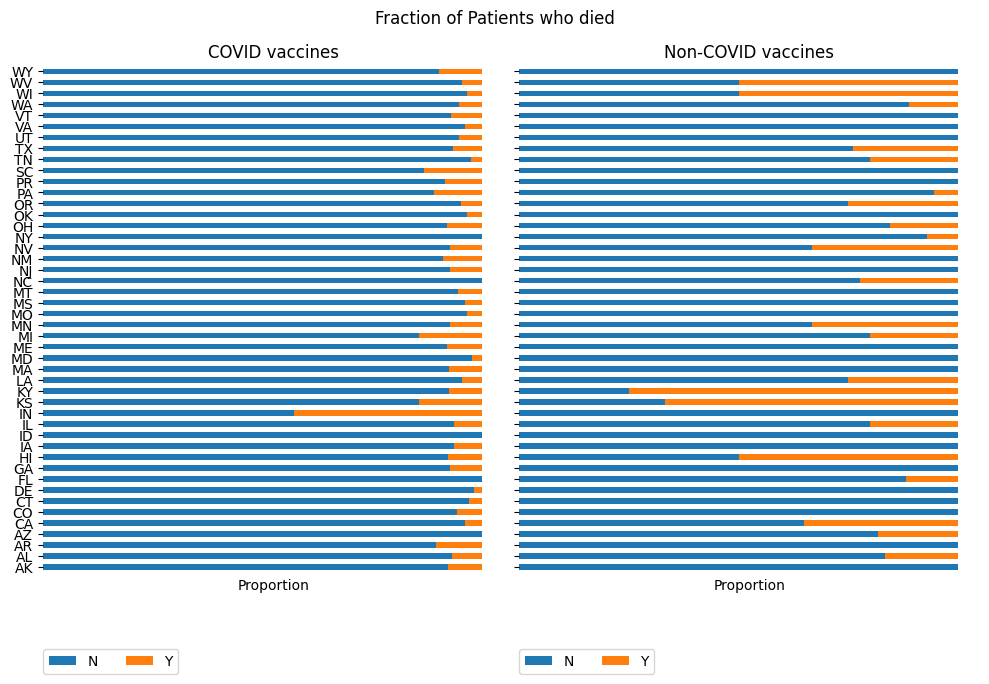

In [69]:
sel = dff.VAX_TYPE == 'COVID19'

dummy = dff.copy()
dummy.DIED[dummy.DIED != 'Y'] = 'N'
fig, ax = plt.subplots(1,2, figsize = (10,7), sharey = True)
hax = ax[0]
tabProp = pd.crosstab(index = dummy[sel]['STATE'], columns = dummy[sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'COVID vaccines')

hax = ax[1]
tabProp = pd.crosstab(index = dummy[~sel]['STATE'], columns = dummy[~sel]['DIED'], normalize = "index")
tabProp.plot(kind='barh', stacked=True, ax = hax)
hax.legend(loc=(0, -0.2), ncol=3)
hax.set(frame_on=False, xticks=[], xlabel = 'Proportion', ylabel = None,
        title = 'Non-COVID vaccines')
plt.suptitle('Fraction of Patients who died')
plt.tight_layout()

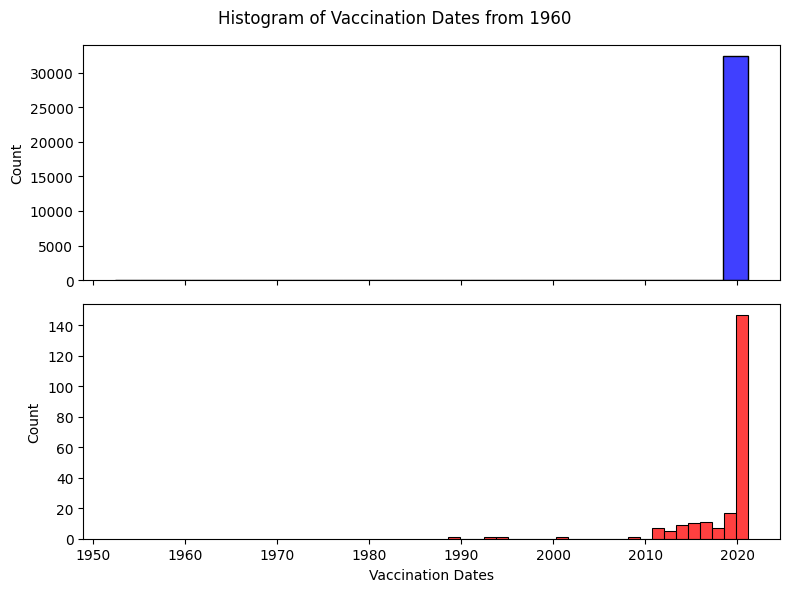

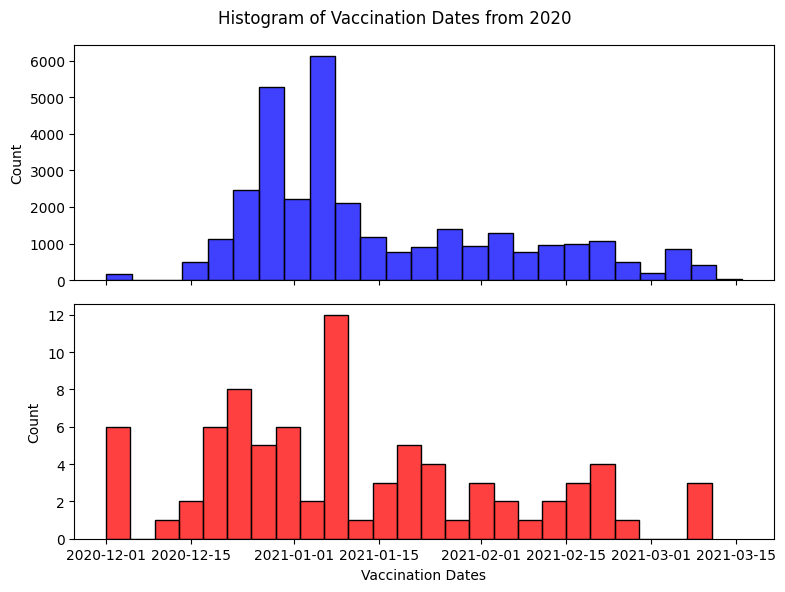

In [21]:
#How do the reports related to the date of vaccination?
dff['bVaxDates'] = pd.to_datetime(dff['VAX_DATE'], format= '%m/%d/%Y')

fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex = True)

target_date = pd.to_datetime('12/01/1950', format='%m/%d/%Y')
sel = dff['bVaxDates'] >= target_date
sns.histplot(data=dff[(sel) & (dff.bCOVID == 'Y')], x='bVaxDates', bins=25, color='b', kde=False, ax=ax[0])
sns.histplot(data=dff[(sel) & (dff.bCOVID == 'N')], x='bVaxDates', bins=25, color='r', kde=False, ax=ax[1])

plt.suptitle(f'Histogram of Vaccination Dates from 1960')
plt.xlabel('Vaccination Dates')
plt.tight_layout()


fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex = True)
target_date = pd.to_datetime('12/01/2020', format='%m/%d/%Y')
sel = dff['bVaxDates'] >= target_date
sns.histplot(data=dff[(sel) & (dff.bCOVID == 'Y')], x='bVaxDates', bins=25, color='b', kde=False, ax=ax[0])
sns.histplot(data=dff[(sel) & (dff.bCOVID == 'N')], x='bVaxDates', bins=25, color='r', kde=False, ax=ax[1])

plt.suptitle(f'Histogram of Vaccination Dates from 2020')
plt.xlabel('Vaccination Dates')
plt.tight_layout()


... Patients vaccinated from 2020 reported more side effects than people vaccinates before that, either with COVID-vaccines or other vaccines

## NLP Analysis

In [22]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import re  # Import the regular expressions module

# Download NLTK resources
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords');
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords;
stopwords = set(stopwords.words('english'))
stopwords.update(['of','the','to','be','that','with','on','for','by','at','one', 's', 't', 'n', 'nt', 'don', 'doesn']);

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [46]:
# Function to check if text is in first person
def is_first_person(text):
  if type(text) != str:
    return False
  else:
    text = text.lower()
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    # Check if token indicates first person
    for word, pos in tagged:
        if word in ['i', 'me', 'my', 'mine', 'myself']: #not including plural first person
          return True
  return False

# Apply the function to the DataFrame
dff['FirstPerson'] = dff['SYMPTOM_TEXT'].apply(is_first_person)

In [52]:
y = [np.sum(dff['FirstPerson'] == True), np.sum(dff['FirstPerson'] == False), np.sum([(dff['FirstPerson']) & (dff['bCOVID'] == 'Y')])]
print(f'Among all the {len(dff)} reports, {y[0]} were detected to be written in first person, from which {y[2]} received COVID vaccination')

Among all the 34121 reports, 6492 were detected to be written in first person, from which 6453 received COVID vaccination


The majority of the reports were not written in first person, suggesting that the narratives are manily coming from healthcare records. However, a large number of reports come from the patients, most of them vaccinated against COVID19, which suggest that the context of the pandemic might have raised more awareness in people, leading to more spontaneous reports.

In [25]:
# Preprocess the text
def preprocess_text(text, stopwords):
  # Initialize NLTK's Porter Stemmer
  stemmer = PorterStemmer()
  lemmatizer = WordNetLemmatizer()

  if type(text) != str:
    text = ''

  # Convert text to lowercase
  text = text.lower()

  # Tokenize the sentence
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  text = re.sub(r'\d+', '', text)       # Remove numbers
  #textblb = TextBlob(text)
  #text = textblb.correct().string
  corrected_tokens = word_tokenize(text)

  # Perform POS tagging
  pos_tags = nltk.pos_tag(corrected_tokens)

  # Remove verbs, adverbs, and adjectives, pronouns, articles, conjunctions
  corrected_tokens = [word for word, tag in pos_tags if tag not in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',
                                                                  'RB', 'RBR', 'RBS',
                                                                  'JJ', 'JJR', 'JJS',
                                                                   'PRP', 'PRP$',
                                                                   'DET',
                                                                   'CC',
                                                                   )]
  # Debugging: Print the tokens before stopwords removal
  #print("Tokens before stopwords removal:", corrected_tokens)

  # Remove stopwords
  corrected_tokens = [word for word in corrected_tokens if word not in stopwords]

  # Debugging: Print the tokens after stopwords removal
  #print("Tokens after stopwords removal:", corrected_tokens)

  #Refine the list from None elements:
  corrected_tokens = [token for token in corrected_tokens if token is not None]

  #Normalize words
  #corrected_tokens = [stemmer.stem(word) for word in corrected_tokens]
  corrected_tokens = [lemmatizer.lemmatize(word) for word in corrected_tokens]

  output = ' '.join(corrected_tokens)
  return output


In [26]:
# Apply preprocessing to the DataFrame
dff['processed_text'] = np.repeat(np.nan, len(dff))
dff['processed_length'] = np.repeat(np.nan, len(dff))
for ix in range(len(dff)):
  if type(dff.SYMPTOM_TEXT[ix]) != str:
    continue
  dff['processed_text'][ix] = preprocess_text(dff.SYMPTOM_TEXT[ix], stopwords)
  dff['processed_length'][ix] = len(dff.SYMPTOM_TEXT[ix])


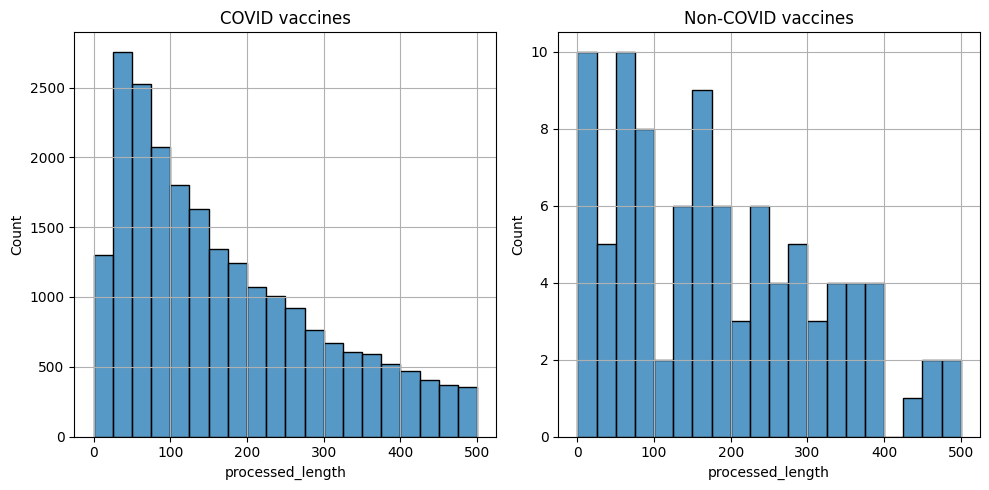

In [27]:
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = False)
binedges = [*range(0, 501, 25)]
sns.histplot(ax = ax[0], data = dff[dff.VAX_TYPE == 'COVID19'], x = 'processed_length', bins = binedges, cbar = True);
ax[0].set_title('COVID vaccines')
ax[0].grid()

sns.histplot(ax = ax[1], data = dff[dff.VAX_TYPE != 'COVID19'], x = 'processed_length', bins = binedges, cbar = True);
ax[1].set_title('Non-COVID vaccines')
ax[1].grid()
plt.tight_layout();

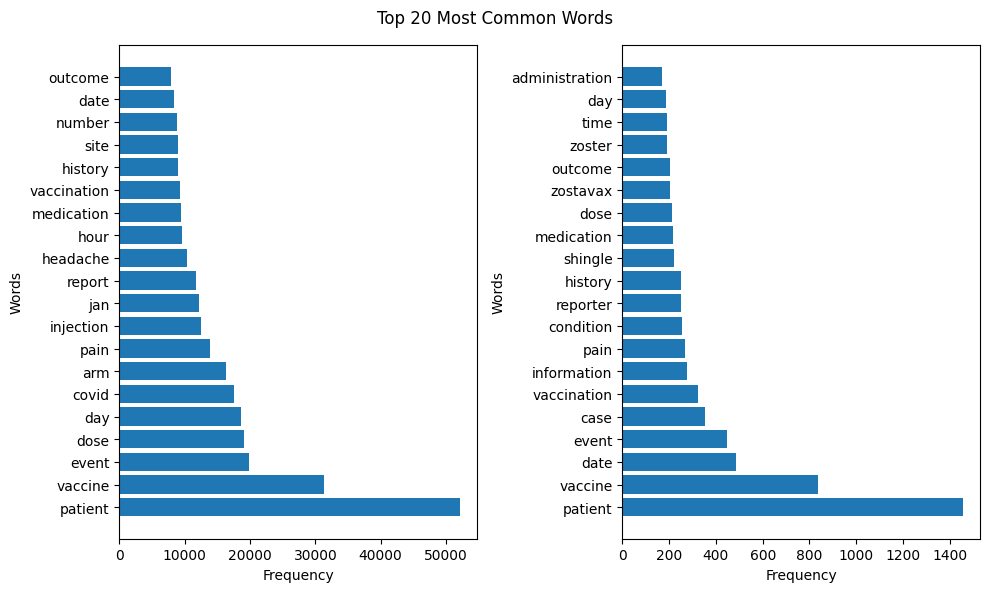

In [28]:
from collections import Counter

dummy = dff.copy()
dummy.dropna(subset = 'processed_text', inplace = True)
dummy.reset_index(drop = True, inplace = True)

# Select the top N most common words
top_n = 20

fig, ax = plt.subplots(1,2, figsize = (10, 6))
hax = ax[0]
sel = dummy.VAX_TYPE == 'COVID19'

# Tokenize the text and remove stopwords
combined_text = ' '.join(dummy['processed_text'][sel])
tokens = word_tokenize(combined_text)
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords] #take only words with letters (not numbers or signs) skipping stopwords

# Count word frequencies
word_freq = Counter(filtered_tokens)
common_words = word_freq.most_common(top_n)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
hax.barh(y = df_common_words['Word'], width = df_common_words['Frequency'])
hax.set_ylabel('Words')
hax.set_xlabel('Frequency')

hax = ax[1]
sel = dummy.VAX_TYPE != 'COVID19'
combined_text = ' '.join(dummy['processed_text'][sel])
tokens = word_tokenize(combined_text)
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]

# Count word frequencies
word_freq = Counter(filtered_tokens)
common_words = word_freq.most_common(top_n)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
hax.barh(y = df_common_words['Word'], width = df_common_words['Frequency'])
hax.set_ylabel('Words')
hax.set_xlabel('Frequency')

plt.suptitle(f'Top {top_n} Most Common Words')
plt.tight_layout()
plt.show()

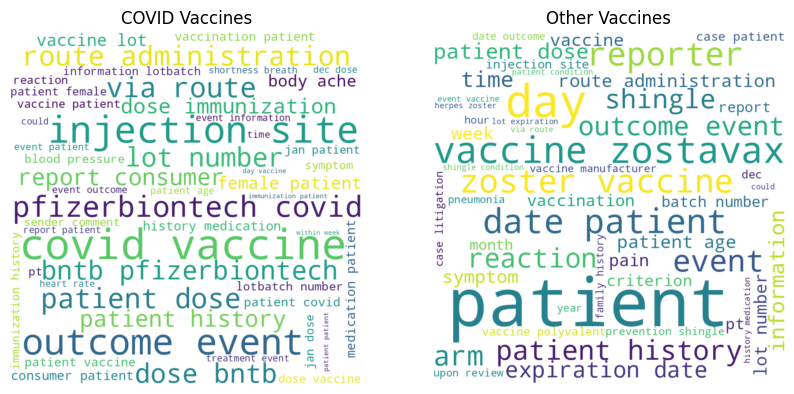

In [29]:
# Create a WordCloud instance
wc = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords, max_words = 50)

fig, ax = plt.subplots(1,2, figsize = (10,10), sharey = False)

var = 'VAX_TYPE'
dummy = dff.copy()
dummy.dropna(subset = 'processed_text', inplace = True)

# Create the WordCloud from the combined strings
combined_text = ' '.join(dummy['processed_text'][dummy[var] == 'COVID19'])
wc.generate(combined_text)

# Display the WordCloud
ax[0].imshow(wc, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('COVID Vaccines')

# Create the WordCloud from the combined strings
combined_text = ' '.join(dummy['processed_text'][dummy[var] != 'COVID19'])
wc.generate(combined_text)

# Display the WordCloud
ax[1].imshow(wc, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Other Vaccines')

plt.show()


The dataset includes a large number of irrelevant words that overlap in the COVID and non-COVID groups. Below I attempted to remove some of the irrelavant words found among the most common ones.

In [30]:
#Remove words that are likely not symptoms:
additional = ['patient', 'covid', 'vaccine', 'dose', 'event', 'day', 'received',
              'reported', 'injection', 'jan', 'hour', 'information', 'lot', 'week',
              'spontaneous', 'report', 'case', 'condition', 'reporter', 'history',
              'medical', 'unspecified', 'unknown', 'provided', 'first', 'second',
              'vaccination', 'received', 'taken', 'date', 'number', 'experienced',
              'considered', 'related', 'number', 'live', 'symptom', 'outcome', 'concomitant',
              'felt', 'body', 'medication', 'included', 'administration', 'contactable', 'pfizerbiontech',
              'started', 'am', 'pm', 'hours', 'minutes', 'within', 'work', 'hospital', 'equipment',
              'staff', 'beginning', 'end', 'though', 'home', 'time', 'like', 'moderna', 'eua', 'route',
              'bntb', 'left', 'right', 'regarding', 'mrna', 'upon', 'pfizer', 'consumer', 'treatment',
              'immunization']
stopwords2 = stopwords.copy()
stopwords2.update(additional)


In [31]:
# Apply preprocessing to the DataFrame
dff2 = dff.copy()
dff2['processed_text'] = np.repeat(np.nan, len(dff2))
dff2['processed_length'] = np.repeat(np.nan, len(dff2))
for ix in range(len(dff2)):
  if type(dff2.SYMPTOM_TEXT[ix]) != str:
    continue
  dff2['processed_text'][ix] = preprocess_text(dff2.SYMPTOM_TEXT[ix], stopwords2)
  dff2['processed_length'][ix] = len(dff2.SYMPTOM_TEXT[ix])


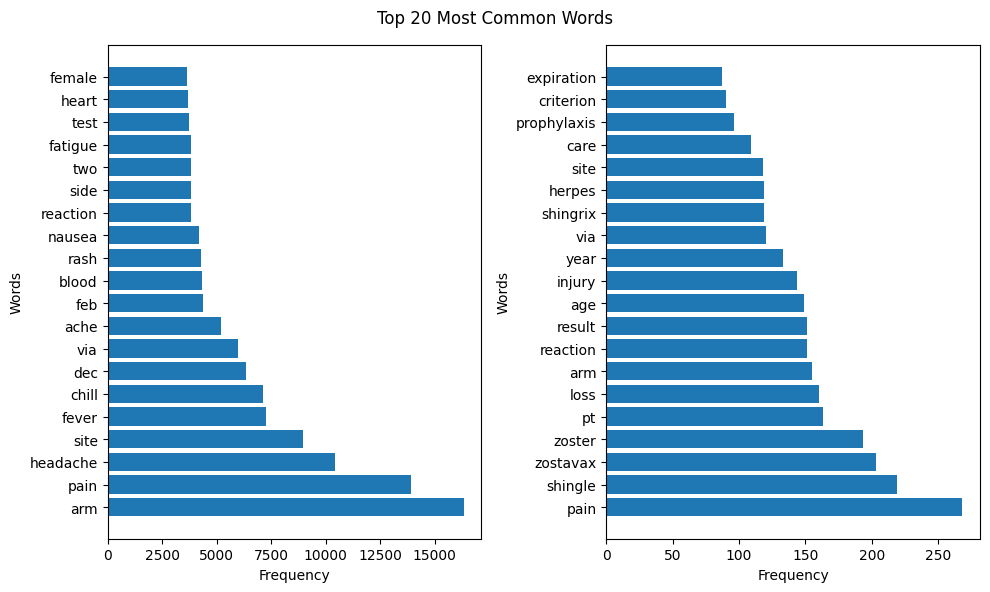

In [32]:
from collections import Counter

dummy = dff2.copy()
dummy.dropna(subset = 'processed_text', inplace = True)
dummy.reset_index(drop = True, inplace = True)

# Select the top N most common words
top_n = 20

fig, ax = plt.subplots(1,2, figsize = (10, 6))
hax = ax[0]
sel = dummy.VAX_TYPE == 'COVID19'

# Tokenize the text and remove stopwords
combined_text = ' '.join(dummy['processed_text'][sel])
tokens = word_tokenize(combined_text)
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords2] #take only words with letters (not numbers or signs) skipping stopwords

# Count word frequencies
word_freq = Counter(filtered_tokens)
common_words = word_freq.most_common(top_n)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
hax.barh(y = df_common_words['Word'], width = df_common_words['Frequency'])
hax.set_ylabel('Words')
hax.set_xlabel('Frequency')

hax = ax[1]
sel = dummy.VAX_TYPE != 'COVID19'
combined_text = ' '.join(dummy['processed_text'][sel])
tokens = word_tokenize(combined_text)
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords2]

# Count word frequencies
word_freq = Counter(filtered_tokens)
common_words = word_freq.most_common(top_n)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
hax.barh(y = df_common_words['Word'], width = df_common_words['Frequency'])
hax.set_ylabel('Words')
hax.set_xlabel('Frequency')

plt.suptitle(f'Top {top_n} Most Common Words')
plt.tight_layout()
plt.show()

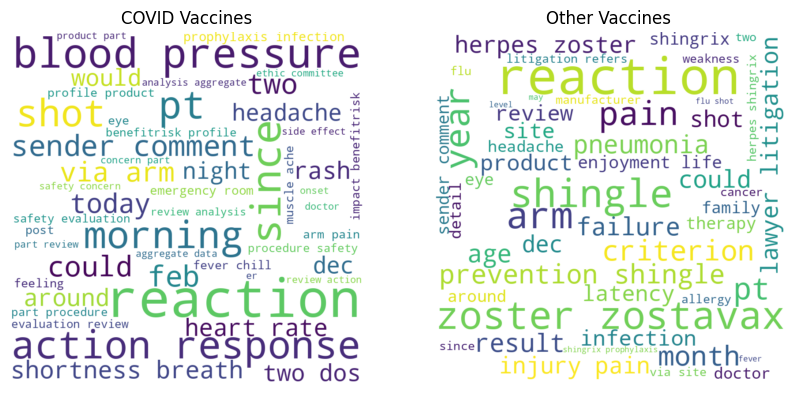

In [33]:
# Create a WordCloud instance
wc = WordCloud(width=800, height=800, background_color='white', stopwords = stopwords2, max_words = 50)

fig, ax = plt.subplots(1,2, figsize = (10,10), sharey = False)

var = 'VAX_TYPE'
dummy = dff2.copy()
dummy.dropna(subset = 'processed_text', inplace = True)

# Create the WordCloud from the combined strings
combined_text = ' '.join(dummy['processed_text'][dummy[var] == 'COVID19'])
wc.generate(combined_text)

# Display the WordCloud
ax[0].imshow(wc, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('COVID Vaccines')

# Create the WordCloud from the combined strings
combined_text = ' '.join(dummy['processed_text'][dummy[var] != 'COVID19'])
wc.generate(combined_text)

# Display the WordCloud
ax[1].imshow(wc, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Other Vaccines')

plt.show()


Interestingly, the word reaction is found to be common to both groups, which could be related to the fact that most of the reports come from people with pre-existing allergies.

Although the data set still has several words that are not related to symptoms, I will proceed to work with is as it is.

Below I will perform a predictive analysis, using a supervised machine learning model to evaluate whether the narratives contain enough information to differentiate both groups of reports.

In [34]:
def runPredictiveAnalysis(X, y, model, n_runs = 20, k_folds = 5):
  #We run the model n_runs times (default = 20) with and k_fold (default = 5) cross validation:
  F1_N = [];
  F1_Y = [];
  Acc = [];
  for ix in range(n_runs):
    print(f'Run # {ix}');
    f1_N = [];
    f1_Y = [];
    acc = []
    #5-fold cross-validation:
    kf = KFold(n_splits=k_folds, shuffle=True)
    for k, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(f'-- validation {k}')
        #training y test sets:
        x_train, x_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(x_train, y_train);

        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)

        rep = classification_report(y_test, y_pred, output_dict = True);
        f1_N.append([rep['N']['f1-score'], ix]);
        f1_Y.append([rep['Y']['f1-score'], ix]);
        acc.append([rep['accuracy'], ix]);
    #print(f'Accuracy of the run #{ix} is {partial_mean(acc)}')
    F1_N.append([partial_mean(f1_N), ix]);
    F1_Y.append([partial_mean(f1_Y), ix]);
    Acc.append([partial_mean(acc), ix]);

  #return the collected accuracy and F1 for both classes, as well as the last train/test sets:
  print('Done!');
  return Acc, F1_N, F1_Y, model, x_train, x_test, y_train, y_test

def partial_mean(h):
  a=np.array(h);
  pm = a[:,0].mean();
  return pm

def plotPerformance(y_test, y_pred, F1_N, F1_Y, Acc):
  #Plotting:
  fig, ax = plt.subplots(1,2,figsize = (15,6));

  #Plot confusion matrix:
  mat = confusion_matrix(y_test, y_pred)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap='inferno_r', ax = ax[0])
  ax[0].set_xlabel('True label')
  ax[0].set_ylabel('Predicted label');
  ax[0].set_title('Model Performance')

  #F1 report and Accuracy:
  dfF0 = pd.DataFrame(F1_N, columns = ['val', 'run']);
  dfF1 = pd.DataFrame(F1_Y, columns = ['val', 'run']);
  dfAcc = pd.DataFrame(Acc, columns = ['val', 'run']);

  sns.lineplot(data = dfF0, x = 'run', y = 'val', label = 'False', marker = 'o', markers=True, ax = ax[1])
  sns.lineplot(data = dfF1, x = 'run', y = 'val',  label = 'True', marker = 'o', markers=True, ax = ax[1])
  sns.lineplot(data = dfAcc, x = 'run', y = 'val', label = 'Accuracy', marker = 'o', markers=True, ax = ax[1])
  ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

  ax[1].set_xlabel('Run #');
  ax[1].set_ylabel('F1_values');
  ax[1].set_title('Performance Curves');

  plt.show();

  print(f'Best accuracy: {np.max(dfAcc.val):.4f} at run# {np.argmax(dfAcc.val)}');
  print(f'Best F1 for Class False: {np.max(dfF0.val):.4f}')
  print(f'Best F1 for Class True: {np.max(dfF1.val):.4f}')

In [74]:
#We form a separate set with the predictors and the response:
dummy = dff2.copy()
dummy.dropna(subset=['processed_text', 'bCOVID'], inplace = True)
dummy.reset_index(drop = True, inplace = True)
X = dummy['processed_text']
y = dummy['bCOVID'].astype('category')

n_runs = 10;
k_folds = 5;


Run # 0
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 1
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 2
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Done!


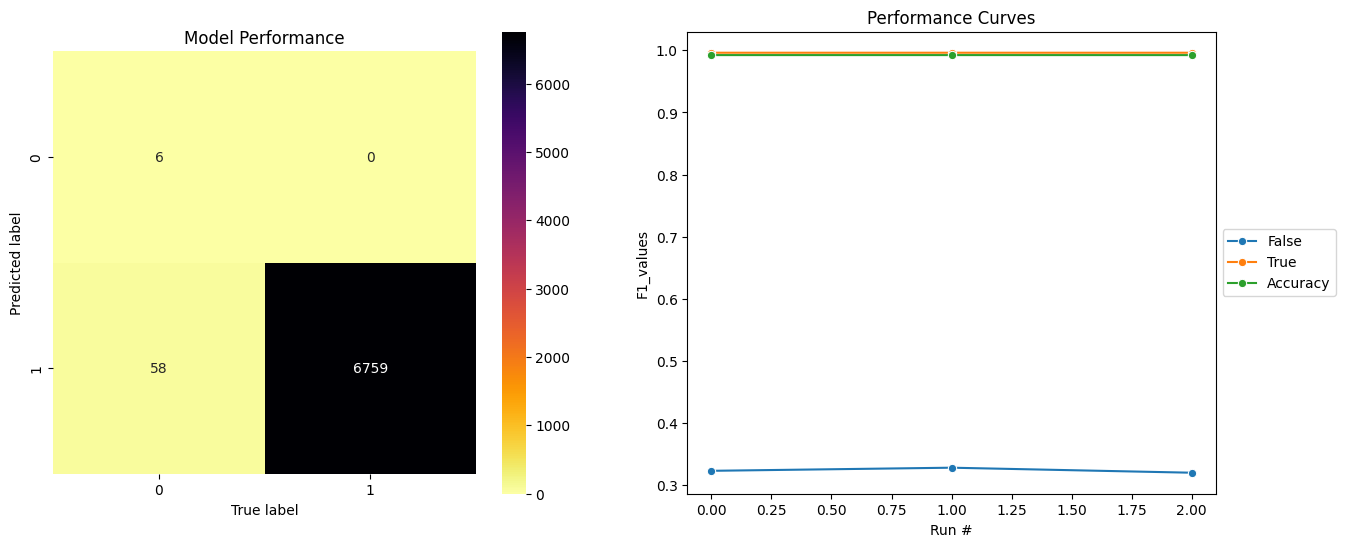

Best accuracy: 0.9924 at run# 1
Best F1 for Class False: 0.3284
Best F1 for Class True: 0.9962


In [73]:
#we generate the model together with the vectorizer using the stopwords filter:
model = make_pipeline(TfidfVectorizer(stop_words = list(stopwords2)), LogisticRegression())

#We train the model several times with cross-validation:
Acc, F1_0, F1_1, fit_model, x_train, x_test, y_train, y_test = runPredictiveAnalysis(X, y, model, n_runs = 3, k_folds = k_folds);

#Accuracy and F1 report with the final model:
y_pred = fit_model.predict(x_test);
plotPerformance(y_test, y_pred, F1_0, F1_1, Acc);

In [55]:
#Let's try to balance the data by undersampling the majority class and oversampling the minority:

covid_vax = dff2[dff2['VAX_TYPE'] == 'COVID19'].reset_index(drop = True)
other_vax = dff2[dff2['VAX_TYPE'] != 'COVID19'].reset_index(drop = True)

modified1 = resample(covid_vax, replace=False, n_samples=round(len(covid_vax)/4), random_state=42)
modified2 = resample(other_vax, replace=True, n_samples=round(len(covid_vax)/4), random_state=42)

# Combine the undersampled majority class and the original minority class
resampled = pd.concat([modified1, modified2])

# Optionally reset the index
resampled.reset_index(drop=True, inplace = True)

Run # 0
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 1
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 2
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 3
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 4
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 5
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 6
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 7
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 8
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Run # 9
-- validation 0
-- validation 1
-- validation 2
-- validation 3
-- validation 4
Done!


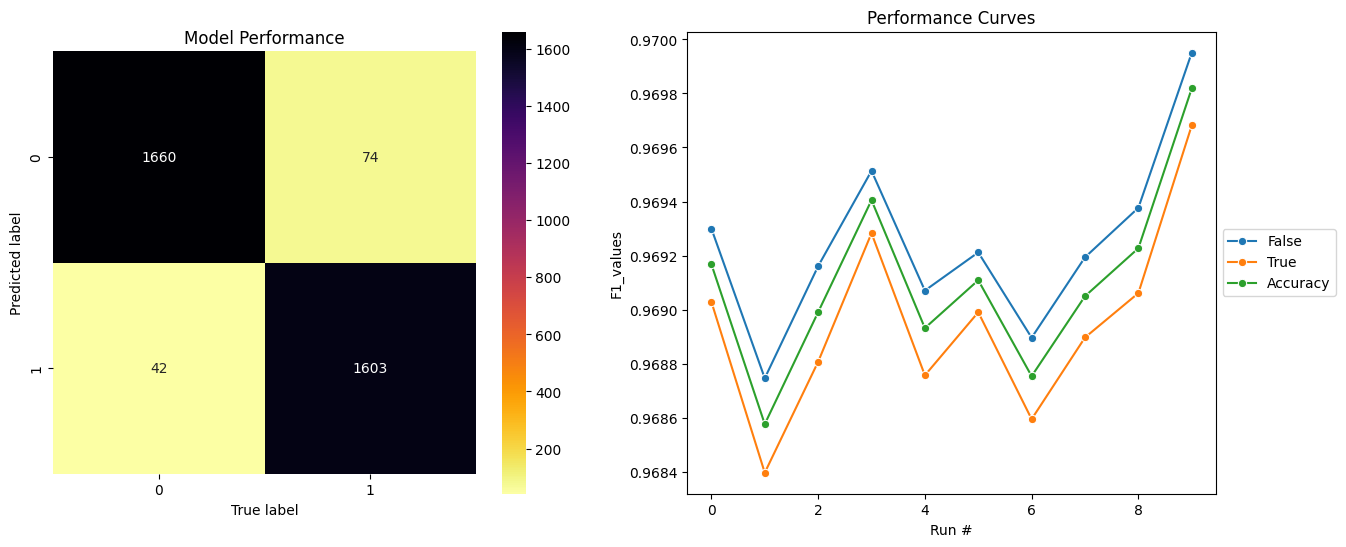

Best accuracy: 0.9698 at run# 9
Best F1 for Class False: 0.9700
Best F1 for Class True: 0.9697


In [56]:
dummy = resampled.copy()

# Drop rows with missing data
dummy.dropna(subset=['processed_text', 'bCOVID'], inplace=True)
dummy.reset_index(drop=True, inplace=True)

# Separate features and target variable
X = dummy['processed_text']
y = dummy['bCOVID'].astype('category')

#we generate the model together with the vectorizer using the stopwords filter:
#MultinomialNB, RandomForestClassifier, GradientBoostingClassifier, LogisticRegression

model = make_pipeline(TfidfVectorizer(stop_words = list(stopwords2)), LogisticRegression())

#We train the model several times with cross-validation:
Acc, F1_0, F1_1, fit_model, x_train, x_test, y_train, y_test = runPredictiveAnalysis(X, y, model, n_runs = n_runs, k_folds = k_folds);

#Accuracy and F1 report with the final model:
y_pred = fit_model.predict(x_test);
plotPerformance(y_test, y_pred, F1_0, F1_1, Acc);

With the data balanced it was possible to see that the trained model was able to distinguish between the 2 types of narratives with high accuracy.

Below I attempted to explore the features the model used to make its predictions:

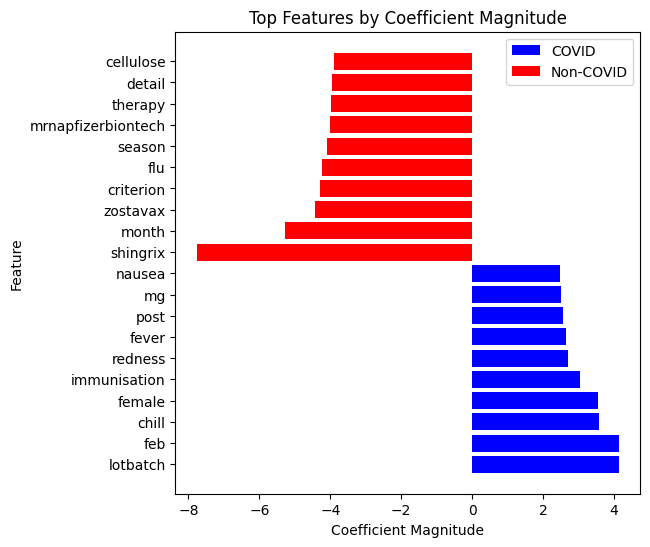

In [39]:
# Access the LogisticRegression component of the pipeline using 'named_steps'
logistic_regression_model = fit_model.named_steps['logisticregression']  # Replace 'logisticregression' with the actual step name
vectorizer = fit_model.named_steps['tfidfvectorizer']

# Extract the coefficients
coefficients = logistic_regression_model.coef_[0]

# Assuming you have a trained TF-IDF vectorizer 'tfidf_vectorizer'
feature_names = vectorizer.get_feature_names_out();

# Pair feature names with their coefficients and sort by magnitude
feature_coefficients = list(zip(feature_names, coefficients))
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

#N features:
N = 10

# Create a DataFrame to associate coefficients with feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude to identify important features
coeff_df = coeff_df.reindex(coeff_df['Coefficient'].abs().sort_values(ascending=False).index)

# Separate positive and negative coefficients for each class
positive_coeffs_class_1 = coeff_df[coeff_df['Coefficient'] > 0]  # Features contributing to class 1
negative_coeffs_class_1 = coeff_df[coeff_df['Coefficient'] < 0]  # Features contributing to class 0
negative_coeffs_class_0 = coeff_df[coeff_df['Coefficient'] < 0]

# Plot the top N features for each class
plt.figure(figsize=(6, 6))
plt.barh(positive_coeffs_class_1['Feature'][:N], positive_coeffs_class_1['Coefficient'][:N], color='b', label='COVID')
plt.barh(negative_coeffs_class_1['Feature'][:N], negative_coeffs_class_1['Coefficient'][:N], color='r', label='Non-COVID')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Top Features by Coefficient Magnitude')
plt.legend()
plt.show()

The top 10 features for either group did not overlap, suggesting that certain key elements are unique to both types of narratives.


Below I used dimensionality reduction to visualize to what extend the data overlaps or separates.

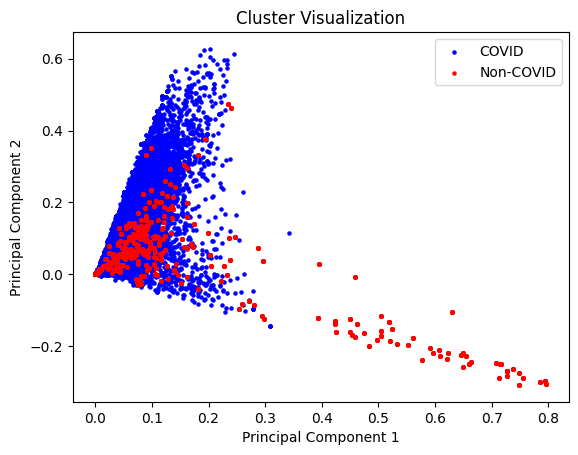

In [81]:
from sklearn.decomposition import TruncatedSVD

dummy = resampled.copy()
dummy['logAllergies'] = np.repeat('Y', len(dummy))
dummy['logAllergies'][np.in1d(dummy['ALLERGIES'], NegL)] = 'N'

dummy['bCOVID'] = np.repeat('Y', len(dummy))
dummy.loc[dummy['VAX_TYPE'] != 'COVID19', 'bCOVID'] = 'N'

# Drop rows with missing data
dummy.dropna(subset=['processed_text', 'bCOVID'], inplace=True)
dummy.reset_index(drop=True, inplace=True)

# Separate features and target variable
X = dummy['processed_text']

vectorizer = fit_model.named_steps['tfidfvectorizer']
X = vectorizer.fit_transform(X)

# Reduce dimensionality for visualization
n_components = 4
svd = TruncatedSVD(n_components=n_components)
X_reduced = svd.fit_transform(X)

# Visualize clusters
y = np.ones(len(X_reduced))
y[dummy['bCOVID'] == 'N'] = 0

plt.scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label = 'COVID', s = 5, color = 'blue')
plt.scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label = 'Non-COVID', s = 5, color = 'red')
plt.legend(loc='best')
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

The scatter plot depicts that many data points overlap, suggesting that those narratives shared many elements between both groups. However several datapoints showed large differences, indicating trully differentiable narratives.

**In summary, the analysis carried out herein shows that regardless of the similarities in the temporal trends of the reports (most of them associated with vaccination from 2020), geographics (the more populous, the more reports), and type of patient who reported (female > male patients, mainly allergic patients), the narratives contained key elements that are unique to reports associated to either COVID19 or other types of vaccines.**